<a href="https://colab.research.google.com/github/Younes-ops/YOLOR-Road-Signs-Object-detection/blob/main/Part_1_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning on traffic sign detection using public data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/Assesement
%pwd

/content/gdrive/MyDrive/Assesement


'/content/gdrive/MyDrive/Assesement'

In [ ]:
#!wget https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip
#!unzip FullIJCNN2013.zip
#!rm FullIJCNN2013.zip

In [ ]:
from random import choices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import shutil
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import albumentations as A



## Exploring The Dataset

In [ ]:
Data_Repository_raw = os.getcwd()+"/FullIJCNN2013/"
Data_Repository = os.getcwd()+"/Data/"
gt_file = os.getcwd()+"/FullIJCNN2013/gt.txt"


gt = pd.read_csv(gt_file, sep = ";", header = None)
gt.columns = ["image", "xmin", "ymin","xmax", "ymax", "class"]
display(gt.head(10))

Background_images = [f"{x:05}.ppm" for x in range(900) if f"{x:05}.ppm" not in gt.image.tolist() ]

print("Images with label Count :", len(gt["image"].unique()))
print("Background images Count (Images Without Label) :", len(Background_images))
print("Total traffic sign instances in the dataset :", len(gt["class"]))
print("Total classes in the dataset :", len(gt["class"].unique()))





,image,xmin,ymin,xmax,ymax,class
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39
5,00003.ppm,742,443,765,466,4
6,00003.ppm,742,466,764,489,9
7,00003.ppm,737,412,769,443,21
8,00004.ppm,898,342,967,409,21
9,00004.ppm,906,407,955,459,2


Images with label Count : 741
Background images Count (Images Without Label) : 159
Total traffic sign instances in the dataset : 1213
Total classes in the dataset : 43


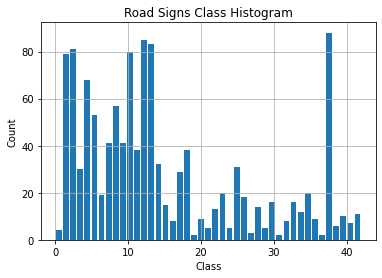

In [ ]:
plt.hist(gt["class"],rwidth=0.8,bins = 43)
plt.ylabel("Count")
plt.xlabel("Class")
plt.title("Road Signs Class Histogram")
plt.grid()

In [ ]:
prohibitory = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16]  # (circular, white ground with red border)
mandatory = [33, 34, 35, 36, 37, 38, 39, 40]  # (circular, blue ground)
danger = [11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]  # (triangular, white ground with red border)


gt["class_name"]=gt["class"].apply(lambda x : "prohibitory" if x in prohibitory else ("mandatory" if x in mandatory else ("danger" if x in danger else "other")))
gt["class"]=gt["class"].apply(lambda x : 3 if x in prohibitory else (1 if x in mandatory else (0 if x in danger else 2)))

In [ ]:
gt

,image,xmin,ymin,xmax,ymax,class,class_name
0,00000.ppm,774,411,815,446,0,danger
1,00001.ppm,983,388,1024,432,1,mandatory
2,00001.ppm,386,494,442,552,1,mandatory
3,00001.ppm,973,335,1031,390,2,other
4,00002.ppm,892,476,1006,592,1,mandatory
...,...,...,...,...,...,...,...
1208,00896.ppm,808,412,846,450,3,prohibitory
1209,00897.ppm,804,526,828,550,2,other
1210,00898.ppm,323,504,355,536,3,prohibitory
1211,00898.ppm,817,510,849,542,3,prohibitory


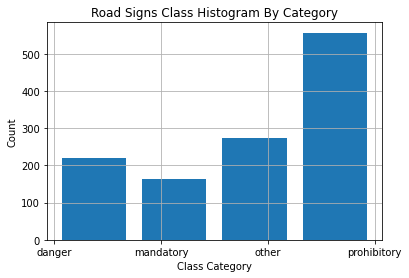

In [ ]:
plt.hist(gt["class_name"],rwidth=0.8,bins = 4)
plt.ylabel("Count")
plt.xlabel("Class Category")
plt.title("Road Signs Class Histogram By Category")
plt.grid()

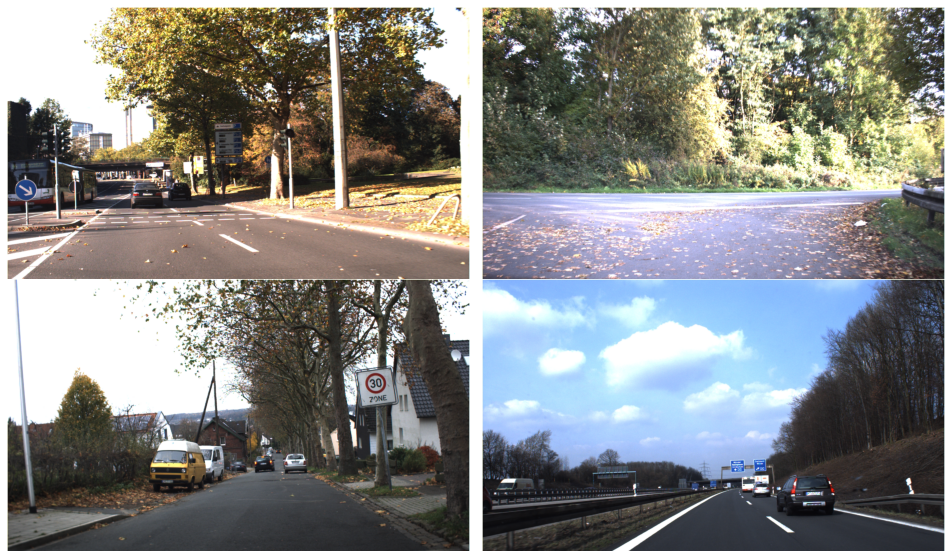

In [ ]:

# Plotting Random Images From the Directory
images_list=np.array([x for x in os.listdir(Data_Repository_raw) if x[-3:] == "ppm"])
fig = plt.figure(figsize=(17, 10))
columns = 2
rows =2
for i in range(1, columns*rows +1):
    img = plt.imread(Data_Repository_raw + np.random.choice(images_list))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

### Utility functions

In [ ]:
#Utility functions


# Converting the labels from their raw format in GTSDB into YOLO format
# Input :   Object Class 
#           Width
#           Height
#           x_min
#           y_min
#           x_max
#           y_max
# Output: Annotation in YOLO Format : 
def convert_to_yolor_annotations(ROI_class, img_width, img_height, x_min, y_min, x_max, y_max):
    ROI_width = x_max - x_min
    ROI_height = y_max - y_min 
    ROI_center_x = (x_min + x_max) / 2
    ROI_center_y = (y_max + y_min) / 2

    ROI_width_rel = ROI_width / img_width
    ROI_height_rel = ROI_height / img_height
    ROI_center_x_rel = ROI_center_x / img_width
    ROI_center_y_rel = ROI_center_y / img_height

    label = "{} {} {} {} {}".format(ROI_class, ROI_center_x_rel, ROI_center_y_rel, ROI_width_rel, ROI_height_rel)

    return label


# Save the images in jpg format in a destination folder and add the label line into the corresponding text file
# Input : input_img : Image 
#         label : Annotation in YOLO Format
#         output_file_path : Path to the directory where to save the image and the label
def write_data(input_img, label, output_file_path):

    if not os.path.isfile(output_file_path):
        plt.imsave(output_file_path + '.jpg', input_img)
        
    # SAVE TXT FILE WITH THE IMG
    f = open(output_file_path + '.txt', "a")
    f.write(label)
    f.write("\n")

    
    
# Display an Image and it's label (ROI)
# Input : img : Image Path
#         object_lb_x1 : X coordinate of the most down right pixel of the object (ROI).
#         object_lb_y1 : Y coordinate of the most down right pixel of the object (ROI).
#         object_width : width of the ROI.
#         object_height : height of the ROI.
def show_img(img,  object_lb_x1, object_lb_y1, object_width, object_height):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    rect = patches.Rectangle(
        (object_lb_x1, object_lb_y1),
        object_width,
        object_height,
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)
    plt.show()

    
# Move files to a destination Directory
# Input : list_of_files : List of paths of files
#         destination_folder : Path to the Destination Directory
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False
  

## Converting the Images and formating the labels

In [ ]:


# Creating The Data repository 

if os.path.isdir(Data_Repository) :
  shutil.rmtree(Data_Repository)

os.mkdir(Data_Repository)




#Labeled Images
#Iterating over gt.txt, converting images to jpg format and saving the labels in yolo format  
for _, row in tqdm(gt.iterrows(),total=gt.shape[0]):
    filename = row[0]
    file_path = Data_Repository_raw + filename
    x_min = int(row[1])
    y_min = int(row[2])
    x_max = int(row[3])
    y_max = int(row[4])
    ROI_class = row[5]

    if os.path.isfile(file_path):  # CHECK FILE EXISTS
        img = plt.imread(file_path)
        img_width, img_height = img.shape[1], img.shape[0]
        #
        label = convert_to_yolor_annotations(ROI_class, img_width, img_height, x_min, y_min, x_max, y_max)
        write_data(img, label, Data_Repository + filename[:-4])


#Background images
#Iterating over the Background images , converting them into jpg format and creating an empty txt file for each image
for filename in tqdm(Background_images) :
    file_path = Data_Repository_raw + filename
    if os.path.isfile(file_path):  # CHECK FILE EXISTS
        img = plt.imread(file_path)
        plt.imsave(Data_Repository + filename[:-4]+ '.jpg', img)
        f = open(Data_Repository + filename[:-4] + '.txt', "w")



        
images = [Data_Repository + x for x in os.listdir(Data_Repository) if x[-3:] == "jpg"]
annotations = [Data_Repository + x for x in os.listdir(Data_Repository) if x[-3:] == "txt"]

images=sorted(images)
annotations=sorted(annotations)

100%|██████████| 159/159 [00:12<00:00, 13.08it/s]


 ## Checking some random images 

/content/gdrive/MyDrive/Assesement/Data/00516.jpg


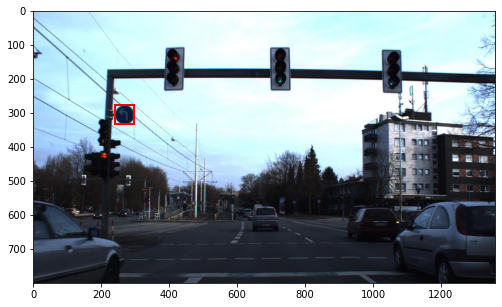

/content/gdrive/MyDrive/Assesement/Data/00012.jpg


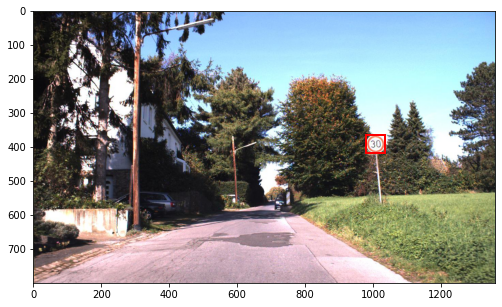

/content/gdrive/MyDrive/Assesement/Data/00655.jpg


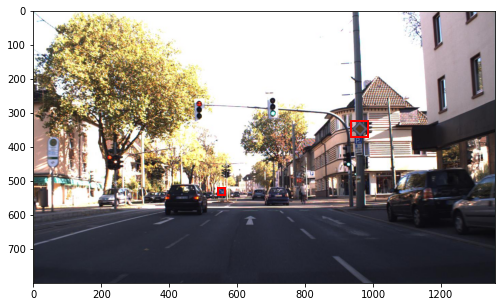

/content/gdrive/MyDrive/Assesement/Data/00498.jpg


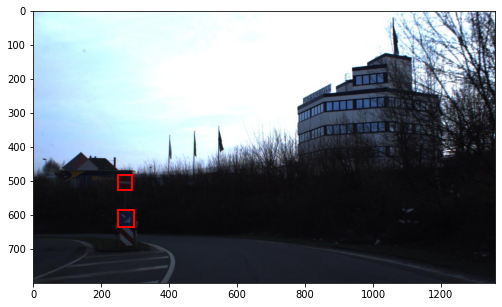

In [ ]:
# Checking some random images if the new label format is coorect
for image_name in np.random.choice(images,size=6):
    
    if image_name[-9:-4]+".ppm" not in Background_images:
        print(image_name)
        img = plt.imread(image_name)
        labels = pd.read_csv(image_name[:-3]+'txt',sep = " ", header = None)
        fig, ax = plt.subplots(1,figsize=(10, 5))
        ax.imshow(img)
        for _, row in labels.iterrows():
            x = (row[1] - row[3]/2)*1360
            y = (row[2] - row[4]/2)*800
            rect = patches.Rectangle(
                (x, y),
                row[3]*1360,
                row[4]*800,
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
        plt.show()


## Train Test Validation Split and Data Organization

In [ ]:

images_train, images_test, annotations_train, annotations_test = train_test_split(images, annotations, test_size=0.2, random_state=42)
images_val, images_test, annotations_val, annotations_test = train_test_split(images_test, annotations_test, test_size=0.5, random_state=42)

os.makedirs(Data_Repository+"images/train")
os.makedirs(Data_Repository+"images/val")
os.makedirs(Data_Repository+"images/test")
os.makedirs(Data_Repository+"labels/train")
os.makedirs(Data_Repository+"labels/val")
os.makedirs(Data_Repository+"labels/test")

# Move the splits into their folders
move_files_to_folder(images_train,Data_Repository+'images/train')
move_files_to_folder(images_val,Data_Repository+'images/val/')
move_files_to_folder(images_test,Data_Repository+'images/test/')
move_files_to_folder(annotations_train,Data_Repository+'labels/train/')
move_files_to_folder(annotations_val,Data_Repository+'labels/val/')
move_files_to_folder(annotations_test,Data_Repository+'labels/test/')

In [ ]:
images_train=[a[:-9]+"images/train"+a[-10:] for a in images_train]
images_test=[a[:-9]+"images/test"+a[-10:] for a in images_test]
images_val=[a[:-9]+"images/val"+a[-10:] for a in images_val]

annotations_train=[a[:-9]+"labels/train"+a[-10:] for a in annotations_train]
annotations_test=[a[:-9]+"labels/test"+a[-10:] for a in annotations_test]
annotations_val=[a[:-9]+"labels/val"+a[-10:] for a in annotations_val]

In [ ]:
# Check classes distribution 
df = pd.DataFrame()

for filename in os.listdir(Data_Repository+'labels/train/'):
    if filename[:-4]+".ppm" not in Background_images:
        df_temp = pd.read_csv(Data_Repository+'labels/train/'+filename, header = None,sep=' ')
        df = df.append(df_temp, ignore_index = True)
    
df

,0,1,2,3,4
0,0,0.584191,0.535625,0.030147,0.04375
1,1,0.737868,0.512500,0.030147,0.05500
2,1,0.304412,0.653750,0.041176,0.07250
3,2,0.736765,0.453125,0.042647,0.06875
4,1,0.697794,0.667500,0.083824,0.14500
...,...,...,...,...,...
965,2,0.613971,0.620000,0.020588,0.03500
966,3,0.608088,0.538750,0.027941,0.04750
967,3,0.249265,0.650000,0.023529,0.04000
968,3,0.612500,0.657500,0.023529,0.04000


In [ ]:
df[:][0].unique()

array([0, 1, 2, 3])

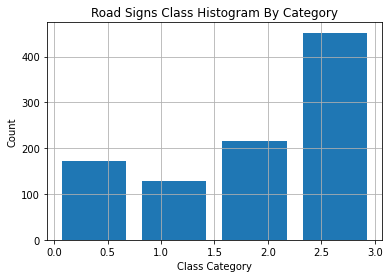

In [ ]:
plt.hist(df[0],rwidth=0.8,bins = 4)
plt.ylabel("Count")
plt.xlabel("Class Category")
plt.title("Road Signs Class Histogram By Category")
plt.grid()

In [ ]:

import albumentations as A
import cv2
import os


# Declare an augmentation pipeline
transform = A.Compose([    
    A.RandomBrightnessContrast(p=0.7),
    A.HueSaturationValue(p=0.7),
    A.ToGray(p=0.3),
    A.MotionBlur(p=0.6)    
])

def aug_image(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Augment an image
    transformed = transform(image=image)
    transformed_image = transformed["image"]
    
    label_path=img_path.replace('images', 'labels').replace('jpg', 'txt')
    f = open(label_path, "r")
    label = f.read()
    return transformed_image , label    

In [ ]:
for image_path in tqdm(images_train) :
    label_path=image_path.replace('images', 'labels').replace('jpg', 'txt')
    if image_path[-9:-4]+".ppm" not in Background_images:
        annot= pd.read_csv(label_path, header = None,sep=' ')
        if 0 in annot[:][0].unique() or 1 in annot[:][0].unique() or 2 in annot[:][0].unique():
            transformed_image1 , label1 = aug_image(image_path)
            transformed_image2 , label2 = aug_image(image_path)
            cv2.imwrite(image_path[:-4]+"_augmented1.jpg", transformed_image1)
            cv2.imwrite(image_path[:-4]+"_augmented2.jpg", transformed_image2)
            
            transformed_image_label_path1=label_path[:-4]+"_augmented1"
            transformed_image_label_path2=label_path[:-4]+"_augmented2"
            
            f = open(transformed_image_label_path1 + '.txt', "w")
            f.write(label1)
            f.close()

            f = open(transformed_image_label_path2 + '.txt', "w")
            f.write(label2)
            f.close()

100%|██████████| 720/720 [01:05<00:00, 10.97it/s]


In [ ]:
# Check classes distribution 
df2 = pd.DataFrame()

for filename in os.listdir(Data_Repository+'labels/train/'):
    if filename[:5]+".ppm" not in Background_images:
        df_temp = pd.read_csv(Data_Repository+'labels/train/'+filename, header = None,sep=' ')
        df2 = df2.append(df_temp, ignore_index = True)
    
df2 

,0,1,2,3,4
0,0,0.584191,0.535625,0.030147,0.04375
1,1,0.737868,0.512500,0.030147,0.05500
2,1,0.304412,0.653750,0.041176,0.07250
3,2,0.736765,0.453125,0.042647,0.06875
4,1,0.697794,0.667500,0.083824,0.14500
...,...,...,...,...,...
2163,3,0.929412,0.381875,0.039706,0.06625
2164,2,0.706985,0.424375,0.041912,0.06375
2165,1,0.709191,0.493125,0.028676,0.05125
2166,2,0.706985,0.424375,0.041912,0.06375


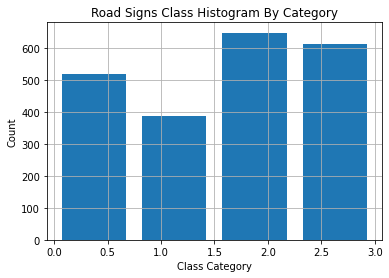

In [ ]:
plt.hist(df2[0],rwidth=0.8,bins = 4)
plt.ylabel("Count")
plt.xlabel("Class Category")
plt.title("Road Signs Class Histogram By Category")
plt.grid()